In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
# !pip install -q kaggle
# !ls ~/.kaggle/kaggle.json
# !ls gdrive/MyDrive/colab_work/kaggle.json

# !mkdir -p ~/.kaggle
# !cp gdrive/MyDrive/colab_work/kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json


## Neural Networks Deep Learning Hyperparameters search on Titanic Disaster dataset

@misc{omalley2019kerastuner
,     title        = {KerasTuner}
,     author       = {O'Malley, Tom and Bursztein, Elie and Long, James and Chollet, Fran\c{c}ois and Jin, Haifeng and Invernizzi, Luca and others}
,     year         = {2019}
,     howpublished = {https://github.com/keras-team/keras-tuner}
}

{cite}`omalley2019kerastuner,
title:KerasTuner,
author:O'Malley, Tom and Bursztein, Elie and Long, James and Chollet, Fran\c{c}ois and Jin, Haifeng and Invernizzi, Luca and others,
year:2019,
howpublished:https://github.com/keras-team/keras-tunerqiime

### [Notebook on Kaggle](https://www.kaggle.com/code/jayyanamandala/neural-networks-deep-learning-hyperparameters-sear)

## import packages

In [23]:
import numpy as np
import pandas as pd
import math
import os
import gc
import re
import inspect
import matplotlib.pyplot as plt
import seaborn as sns

from math import floor
from math import ceil

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [25]:
import tensorflow as tf
import tensorflow.keras as keras

from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Flatten, Input
from keras.models import Sequential
from keras.optimizers import Adadelta, Adagrad, Adam, Adamax, Nadam, SGD, RMSprop, Ftrl
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LeakyReLU, ReLU, ELU, PReLU
from keras.constraints import MaxNorm
from keras.initializers import glorot_uniform, he_uniform, glorot_normal, he_normal
from keras.initializers import uniform, normal, zero


### TPU - GPU setup

In [26]:
# Detect TPU
def tpu_setup():
    try:
        tpu = tf.distribute_cluster_resolver.TPUClusterResolver()
        print('detected: ', tpu.master());
    except ValueError as e:
        print('Error: no TPU: ', e)
        tpu = None

    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
    else:
        strategy = tf.distribute.get_strategy()

    return strategy


In [27]:
def gpu_setup():
    # Detect GPUs, return appropriate strategy
    gpus = tf.config.experimental.list_physical_devices('GPU')
    
    if gpus:
        try:
            # setup up GPU memory growth as True for each GPU
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            strategy = tf.distribute.MirroredStrategy()
            print(f'using: {len(gpus)}')
        except:
            strategy = tf.distribute.get_strategy()
            
        return strategy


In [28]:
# Setting TPU or GPU strategy for this session
# strategy = tpu_setup()
# strategy = gpu_setup()
# print('Replicas in strategy: ', replicas)                 # object has no attribute 'num_replicas_in_sync'
# !nvidia-smi

In [29]:
# function to clear model and garbage collector
def clear_bags(model):
  del model
  gc.collect()

def print_null(DF:pd.core.frame.DataFrame):
    print(DF.isnull().sum())


### load and clean Titanic Disaster dataset

load Ttitanic Disaster train and test data. you will see we have:  
for training: 891 rows and 12 columns  
for testing: 418 rows and 11 columns (does not include `Survived` column)

In [59]:
train_df = pd.read_csv('../datasets/guru/train.csv')
test_df = pd.read_csv('../datasets/guru/test.csv')
print(train_df.shape, test_df.shape)

(891, 12) (418, 11)


Split `PassengerId` column from train dataset and create `true` label dataset - y_train  
Remove columns that do not add to predictions - columns that do not affect Survival outcomes  
Columns like: `PassengerId`, `Name`, `Ticket`, `Fare`  
Drop same columns as above from `test` dataset
Drop `Survived` since we already created `y_train` dataset

For training - we now have a total of `771` rows and `7` columns  
For testing  - we now have a total of `355` rows and `7` columns 

In [61]:
train_df.dropna(subset=['Embarked'], inplace=True)        # drop 2 rows
test_df.dropna(subset=['Embarked'], inplace=True)

In [63]:
train_df[(train_df['Age'].isnull() & train_df['Cabin'].isnull() )]
test_df[(test_df['Age'].isnull() & test_df['Cabin'].isnull() )]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
10,902,3,"Ilieff, Mr. Ylio",male,NaN,0,0,349220,7.8958,NaN,S
22,914,1,"Flegenheim, Mrs. Alfred (Antoinette)",female,NaN,0,0,PC 17598,31.6833,NaN,S
29,921,3,"Samaan, Mr. Elias",male,NaN,2,0,2662,21.6792,NaN,C
33,925,3,"Johnston, Mrs. Andrew G (Elizabeth Lily"" Watson)""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
36,928,3,"Roth, Miss. Sarah A",female,NaN,0,0,342712,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
408,1300,3,"Riordan, Miss. Johanna Hannah""""",female,NaN,0,0,334915,7.7208,NaN,Q
410,1302,3,"Naughton, Miss. Hannah",female,NaN,0,0,365237,7.7500,NaN,Q
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [64]:
y_train = train_df['Survived']
train_df.drop(['PassengerId', 'Survived','Name','Ticket','Fare'], axis=1, inplace=True)
print(train_df.shape, y_train.shape)

passengerId = test_df['PassengerId']
test_df.drop(['PassengerId', 'Name','Ticket','Fare'], axis=1, inplace=True)
print(test_df.shape)

(889, 7) (889,)
(418, 7)


### column `Age` clean-up

In [65]:
train_mean_age = train_df['Age'].mean(numeric_only=True)
test_mean_age = test_df['Age'].mean(numeric_only=True)
train_quant_age = train_df['Age'].quantile(0.75)
test_quant_age = test_df['Age'].quantile(0.75)
print(train_mean_age, train_quant_age)
print(test_mean_age, test_quant_age)

ma = train_mean_age
mb = train_quant_age
if train_mean_age > train_quant_age:
    mb = ma
    ma = train_quant_age

train_df['Age'] = train_df.apply(
    lambda row: np.random.randint(ma, mb) if np.isnan(row['Age']) else row['Age'], axis=1
)
test_df['Age'] = test_df.apply(
    lambda row: np.random.randint(ma, mb) if np.isnan(row['Age']) else row['Age'], axis=1
)

29.64209269662921 38.0
30.272590361445783 39.0


In [66]:
# update solumns 'SibSp' and 'Parch' with '0' entries to 1 
# assuming at least one member in party
train_df.SibSp = train_df.SibSp.replace({0:1})
train_df.Parch = train_df.Parch.replace({0:1})

test_df.SibSp = test_df.SibSp.replace({0:1})
test_df.Parch = test_df.Parch.replace({0:1})

### column `Cabin` clean-up

In [67]:
# # Regression runs
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

# fill NaNs in both Train and Test data with 'T' - only Cabin in train dataset not visible in test dataset
train_df['Cabin'] = train_df['Cabin'].fillna('T')
test_df['Cabin'] = test_df['Cabin'].fillna('T')

# compress values in 'Cabin' to a Aplhabet
train_df['Cabin'] = train_df['Cabin'].map(lambda x: re.sub("\d+","", x))
train_df['Cabin'] = train_df['Cabin'].map(lambda x: re.sub("\s+","", x))
train_df['Cabin'] = train_df['Cabin'].map(lambda x: re.sub(r'(.)\1+', r'\1',x))

test_df['Cabin'] = test_df['Cabin'].map(lambda x: re.sub("\d+","", x))
test_df['Cabin'] = test_df['Cabin'].map(lambda x: re.sub("\s+","", x))
test_df['Cabin'] = test_df['Cabin'].map(lambda x: re.sub(r'(.)\1+', r'\1',x))

print(test_df.Cabin.unique())
print(train_df.Cabin.unique())

['T' 'B' 'E' 'A' 'C' 'D' 'FG' 'F' 'G' 'FE']
['T' 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'FG' 'FE']


### one-hot encoding of categorical columns

In [68]:
print('Train cabin:', len(train_df['Cabin'].unique()))
print('Train embarked:', len(train_df['Embarked'].unique()))

print('\nTrain gender:', len(train_df['Sex'].unique()))
print('Test gender:', len(test_df['Sex'].unique()))

print('\nTest cabin:', len(test_df['Cabin'].unique()))
print('Test embarked:', len(test_df['Embarked'].unique()))

Train cabin: 10
Train embarked: 3

Train gender: 2
Test gender: 2

Test cabin: 10
Test embarked: 3


In [69]:
print_null(train_df)
print_null(test_df)

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Cabin       0
Embarked    0
dtype: int64
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Cabin       0
Embarked    0
dtype: int64


In [70]:
print(train_df.shape, test_df.shape)
train_df = pd.get_dummies(train_df)

test_df = pd.get_dummies(test_df)
print(train_df.shape, test_df.shape)

(889, 7) (418, 7)
(889, 19) (418, 19)


one last check to make sure columns in training and test datasets match   
if columns do not match we can raise exception or drop the offending columns and continue  
**Note** if the number of columns between train and test sets do not match, do not proceed

here the code drops mis-matched columns and continues with hyperparameter tuning

In [71]:
# before split drop columns that don't match between train and test
for i in train_df.columns:
    # print(f'column:-{i}-')
    if i not in test_df.columns:
        print(f'column:-{i}- does not exist in test_df')
        # train_df.drop(i, inplace=True, axis=1)
        raise Exception(f'column:-{i}- does not exist in test_df')
    
for i in test_df.columns:
    # print(f'column:-{i}-')
    if i not in train_df.columns:
        print(f'column:-{i}- does not exist in train_df')
        # test_df.drop(i, inplace=True, axis=1)
        raise Exception(f'column:-{i}- does not exist in test_df')

print(train_df.shape, test_df.shape, y_train.shape)

(889, 19) (418, 19) (889,)


convert `True` to `1` and `False` to `0`   
This is a requirement to process data in Neural Networks

In [72]:
# convert True/False to 1 & 0
train_df = train_df.replace({True: 1, False: 0})
test_df = test_df.replace({True: 1, False: 0})

scale data using SkLearn StandardScaler    
Please use other scalers if you think it might improve the model

we only scale two columns in both train and test datasets  
1. Age
2. Cabin

In [73]:
# sc = StandardScaler()
# train_df['Age_scaled'] = sc.fit_transform(train_df[['Age']])
# test_df['Age_scaled'] = sc.transform(test_df[['Age']])
# train_df.drop(['Age'], inplace=True, axis=1)
# test_df.drop(['Age'], inplace=True, axis=1)

In [74]:
# train_df.shape, y_train.shape, test_df.shape

In [75]:
# # scale 'Cabin' as well 
# train_df['Cabin_scaled'] = sc.fit_transform(train_df[['Cabin']])
# test_df['Cabin_scaled'] = sc.transform(test_df[['Cabin']])
# train_df.drop(['Cabin'], inplace=True, axis=1)
# test_df.drop(['Cabin'], inplace=True, axis=1)

In [76]:
# ## check data types of train and test - except for Age, all should be categorical
# train_df.shape, y_train.shape, y_train.shape

### scale train and test values to max of each dataframe

In [77]:
# scale all values of train_df between 0 amd max value over all columns
# train_df.max(axis=0).max()
train_df /= train_df.max(axis=0).max()
test_df /= test_df.max(axis=0).max()

split trainingset into training and validation datasets.  
Optimal woule be if we did not have to split training set to create validation dataset

print shape to make sure:  
1. number of columns match between train and test datasets
2. number of rows match between train and validation datasets


In [78]:
# split train dataset into train and validation datasets
# train_df_copy = train_df.copy()
train_X, val_X, train_y, val_y = train_test_split(train_df, 
                                                  y_train, 
                                                  test_size=0.3, 
                                                  random_state=42,
                                                 shuffle=False)

In [79]:
print(train_X.shape, val_X.shape, train_y.shape, val_y.shape)

(622, 19) (267, 19) (622,) (267,)


<hr><br>
<hr>

### Neural Networks - Deep Learning Hyperparameter Tuning

In [80]:
seed = 7
tf.random.set_seed(seed)

# create dictionary to store hyper-parameters
hyper_params = dict()

Declare defaults to setup up Deep Learning Neural Network to hypertune parameters

In [81]:
def_batch = 32
def_epoch = 100
def_num_layers = 4
def_dropout = 0.2
def_neurons = math.ceil(train_X.shape[1] * def_batch)

print(
    f"{'def_neurons:':<15}{def_neurons:>10}",
    f"{'def_num_layers:':<15}{def_num_layers:>10}",
    f"{'def_batch:':<15}{def_batch:>10}",
    f"{'def_epoch:':<15}{def_epoch:>10}",
    sep='\n'
)


def_neurons:          608
def_num_layers:         4
def_batch:             32
def_epoch:            100


### **create Deep Learning Neural Netowrk model to Tune hyper-parameters**

In [82]:
# default values to setup a Keras model
hyper_params['learning_rate']     , best_learning_rate       = None, None  # 0.001
hyper_params['momentum']          , best_momentum            = None, None  # 0.1
hyper_params['init_mode']         , best_init_mode           = None, None # 'he_normal'
hyper_params['activation']        , best_activation          = 'relu', 'relu'
hyper_params['dropout']           , best_dropout             = None, None  # 0.2
hyper_params['weight_constraint'] , best_weight_constraint   = None, None  # 4.0
hyper_params['neurons']           , best_neurons             = def_neurons, def_neurons  # 256
hyper_params['optimizer']         , best_optimizer           = 'Adam', 'Adam'  # 'Adam'
hyper_params['epochs']            , best_epoch_num           = def_epoch, def_epoch
hyper_params['batch_size']        , best_batch_size          = def_batch, def_batch
hyper_params['num_hidden_layers'] , best_num_hidden_layers   = 3, 3

# input dataframe
inputdf=train_df         # define the dataframe to use for input_shape - Neural Networks only need number of features


In [83]:
def create_hyper_model(lr=best_learning_rate,
                       momentum=best_momentum,
                       init_mode=best_init_mode,
                       activation=best_activation,
                       dropout=best_dropout,
                       weight_constraint=best_weight_constraint,
                       neurons=best_neurons,
                       optimizer=best_optimizer,
                       num_hidden_layers=best_num_hidden_layers,
                      inputdf=inputdf):
    
    # clear model session and recreate - 
    # according to Keras docs works for a functional model
    keras.backend.clear_session()
    dense_dict = inspect.signature(Dense)
    dropout_dict = inspect.signature(Dropout)
    batch_norm_dict = inspect.signature(BatchNormalization)
    
    ###################################################
    # get defaults for hyper-search parameter values
    ###################################################
    # ValueError: Unknown initializer: 'glorot_uniform'. 
    # Please ensure this object is passed to the `custom_objects` argument.
    if init_mode is None:
        k = 'kernel_initializer'
        # val = str(dense_dict.parameters[k]).split('=')[1]
        init_mode = str(dense_dict.parameters[k]).split('=')[1] 
        init_mode = 'glorot_normal'

    if activation is None:
        k = 'activation'
        # val = str(dense_dict.parameters[k]).split('=')[1]
        activation = str(dense_dict.parameters[k]).split('=')[1] 
         
    if weight_constraint is None:
        k = 'kernel_constraint'
        # val = str(dense_dict.parameters[k]).split('=')[1]
        # weight_constraint = str(dense_dict.parameters[k]).split('=')[1] 
        weight_constraint = 4.0

    if lr is None:    # learning_rate - optimizer
        lr = 0.001
    
    if momentum is None:
        k = 'momentum'
        # val = str(dense_dict.parameters[k]).split('=')[1]
        momentum = np.float32(str(batch_norm_dict.parameters[k]).split('=')[1])
        # momentum = 0.1

    if dropout is None:
        dropout = 0.2

    ###################################################
    # function to return a list of layers depending on the 
    # number asked and number_of_neurons in first layer
    ###################################################
    def return_num_layers(nn_num=neurons, n_layers=num_hidden_layers):
        layers = []

        divn = 1 if n_layers <= 1 else (n_layers -1)
        # first layer to contain all neurons
        first_lyr_units = neurons

        # last layer (before output) is:
        last_lyr_units = neurons // n_layers
        
        incr_by = (last_lyr_units - first_lyr_units) / divn
        num_neurons = first_lyr_units
        
        # print(f'num_neurons:{num_neurons} - incr_by:{incr_by}')
        for i in range(1, n_layers + 1):
            layers.append(round(math.ceil(num_neurons)))
            # print(f'layer:{i} - num_neurons:{num_neurons} - layers:{layers}')
            num_neurons = num_neurons + incr_by

        return layers

    
    # neurons = math.ceil(neurons)
    neurons = math.ceil(inputdf.shape[1] * (best_batch_size / 2) )
    num_lyrs = return_num_layers(neurons, num_hidden_layers)
    # print('num_lyrs ', num_lyrs)
    
    ###################################################
    # create model
    ###################################################
    model = Sequential()
    # model.add(Input(shape=(inputdf.shape[1],)))   # used in functional

    model.add(Dense(num_lyrs[0] * 2, input_shape=(inputdf.shape[1],), 
                    kernel_initializer=init_mode, activation=activation,
                    kernel_constraint=MaxNorm(weight_constraint)))

    if momentum > 0.5:
        model.add(BatchNormalization(momentum=momentum))

    if len(num_lyrs) > 2:
        for i in range(1, num_hidden_layers -1):
            model.add(Dense(num_lyrs[i -1] * ( i / num_hidden_layers ), 
                            kernel_initializer=init_mode, activation=activation,
                            kernel_constraint=MaxNorm(weight_constraint)))
    
    # model.add(Dense(neurons//2, kernel_initializer=init_mode, activation=activation,
    #               kernel_constraint=MaxNorm(weight_constraint)))

    if dropout > 0.1:
        model.add(Dropout(dropout))

    # model.add(Flatten())
    if len(num_lyrs) > 1:
        model.add(Dense(num_lyrs[-1], kernel_initializer=init_mode, activation=activation,
                        kernel_constraint=MaxNorm(weight_constraint)))
    
    model.add(Dense(1, kernel_initializer=init_mode, activation='sigmoid'))
    ###################################################
    
    # Compile model
    opt=keras.optimizers.get(optimizer)   # opt.__dir__ to know what can be set
    opt.learning_rate=lr
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

### create model (default settings) before hyper-parameter tuning to check current layers and parameters

In [84]:
cvmodel = create_hyper_model()
cvmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 608)               12160     
                                                                 
 batch_normalization (BatchN  (None, 608)              2432      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 101)               61509     
                                                                 
 dropout (Dropout)           (None, 101)               0         
                                                                 
 dense_2 (Dense)             (None, 101)               10302     
                                                                 
 dense_3 (Dense)             (None, 1)                 102       
                                                        

### **Tune hyperparameters**

if you have the resources you can tune on as many hyperparmaters as you wish  
for this Notebook only tuned on a few with limited sets of inputs fo each parameter

In [85]:
clear_bags(cvmodel)
# cvmodel = KerasClassifier(build_fn=create_hyper_model, verbose=0)

# cvmodel = KerasClassifier(build_fn=create_hyper_model, verbose=0)

num_hidden_layers = [2, 3, 4, 5]
batch_size=[16, 32, 64]
epochs = [30, 50, 70, 90]
neurons = [128, 256, 512]

# optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adam']

learn_rate = [0.001, 0.01, 0.1]
momentum = [0.0, 0.2, 0.4, 0.6]

# init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
init_mode = ['glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']

# activation = ['relu', 'tanh', 'linear', 'selu', 'elu', 'leaky_relu', 'exponential','gelu','mish']
activation = ['relu', 'tanh', 'leaky_relu']

weight_constraint = [0.1, 1.0, 2.0]
dropout_rate = [0.3, 0.5, 0.6, 0.7]

cvmodel = KerasClassifier(build_fn=create_hyper_model,
                          neurons = neurons,
                          num_hidden_layers = num_hidden_layers,
                          # optimizer = optimizer,
                          # lr = learn_rate,
                          # momentum = momentum,
                          # init_mode = init_mode,
                          # activation = activation,                          
                          # weight_constraint = weight_constraint,
                          dropout = dropout_rate,
                          epochs= epochs,
                          batch_size = batch_size,
                          inputdf=train_df,
                          verbose=0,
                          )

# create param_grid dictionary
param_grid = dict(batch_size=batch_size,
                  # optimizer=optimizer,
                  # lr=learn_rate,
                  neurons=neurons,
                  num_hidden_layers = num_hidden_layers,
                  # momentum=momentum,
                  # init_mode=init_mode,
                  # activation=activation,
                  # weight_constraint=weight_constraint,
                  dropout=dropout_rate,
                  epochs=epochs)


In [86]:
# GridSearchCV on all hyper-parameters
grid = GridSearchCV(estimator=cvmodel, param_grid=param_grid, n_jobs = 1, cv = 3)
grid.fit(train_df,y_train)

GridSearchCV(cv=3,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x000001AD1E16D880>,
             n_jobs=1,
             param_grid={'batch_size': [16, 32, 64],
                         'dropout': [0.3, 0.5, 0.6, 0.7],
                         'epochs': [30, 50, 70, 90], 'neurons': [128, 256, 512],
                         'num_hidden_layers': [2, 3, 4, 5]})

In [87]:
print(f'best_fit:{grid.best_score_} best_params:{grid.best_params_}')
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']

for mean, std, param in zip(means, stds, params):
    print(f'mean:{mean} - std:{std} - param:{param}')

best_fit:0.8335494597752889 best_params:{'batch_size': 32, 'dropout': 0.6, 'epochs': 50, 'neurons': 512, 'num_hidden_layers': 4}
mean:0.8088126182556152 - std:0.025284365145728648 - param:{'batch_size': 16, 'dropout': 0.3, 'epochs': 30, 'neurons': 128, 'num_hidden_layers': 2}
mean:0.8043080965677897 - std:0.021185533496844506 - param:{'batch_size': 16, 'dropout': 0.3, 'epochs': 30, 'neurons': 128, 'num_hidden_layers': 3}
mean:0.8020634253819784 - std:0.025274038848429974 - param:{'batch_size': 16, 'dropout': 0.3, 'epochs': 30, 'neurons': 128, 'num_hidden_layers': 4}
mean:0.7919169068336487 - std:0.022977414136208053 - param:{'batch_size': 16, 'dropout': 0.3, 'epochs': 30, 'neurons': 128, 'num_hidden_layers': 5}
mean:0.802067220211029 - std:0.02684067132807802 - param:{'batch_size': 16, 'dropout': 0.3, 'epochs': 30, 'neurons': 256, 'num_hidden_layers': 2}
mean:0.7986964186032613 - std:0.029369623230626665 - param:{'batch_size': 16, 'dropout': 0.3, 'epochs': 30, 'neurons': 256, 'num_hidd

In [88]:
# grid.best_params_.keys()

In [123]:
def list_params():

    # mark these as globals ince values might change
    # also get error 'Unbound LocalError' 
    global best_optimizer, best_neurons, num_hidden_layers, best_weight_constraint, best_dropout
    global best_activation, best_init_mode, best_learning_rate, best_momentum, best_epoch_num
    global best_batch_size
    
    # capture best values for each hyper-parameter if evailable in gridCV run 
    if 'optimizer' in grid.best_params_.keys():
        best_optimizer= grid.best_params_['optimizer']
        
    if 'epochs' in grid.best_params_.keys():
        best_epoch_num = grid.best_params_['epochs']

    if 'batch_size' in grid.best_params_.keys():
        best_batch_size = grid.best_params_['batch_size']

    if 'lr' in grid.best_params_.keys():
        best_learning_rate = grid.best_params_['lr']

    if 'momentum' in grid.best_params_.keys():
        best_momentum = grid.best_params_['momentum']

    if 'init_mode' in grid.best_params_.keys():
        best_init_mode= grid.best_params_['init_mode']

    if 'activation' in grid.best_params_.keys():
        best_activation= grid.best_params_['activation']

    if 'dropout' in grid.best_params_.keys():
        best_dropout = grid.best_params_['dropout']

    if 'neurons' in grid.best_params_.keys():
        best_neurons = grid.best_params_['neurons']

    if 'weight_constraint' in grid.best_params_.keys():
        best_weight_constraint = grid.best_params_['weight_constraint']

    if 'num_hidden_layers' in grid.best_params_.keys():
        best_num_hidden_layers = grid.best_params_['num_hidden_layers']
        
    ## add to hyper_params dictionary
    hyper_params['optimizer'] = best_optimizer
    hyper_params['dropout'] = best_dropout
    hyper_params['neurons'] = best_neurons
    hyper_params['weight_constraint'] = best_weight_constraint
    hyper_params['activation'] = best_activation
    hyper_params['init_mode'] = best_init_mode
    hyper_params['learning_rate'] = best_learning_rate
    hyper_params['momentum'] = best_momentum
    hyper_params['epochs'] = best_epoch_num
    hyper_params['batch_size'] = best_batch_size

    hyper_params['num_hidden_layers'] = best_num_hidden_layers
    # print(best_num_hidden_layers)

    ## print best values
    print('best_optimizer: ', best_optimizer)
    print('best_neurons: ', best_neurons)
    print('num_hidden_layers: ', best_num_hidden_layers)
    print('best_weight_constraint: ', best_weight_constraint)
    print('best_dropout: ', best_dropout)
    print('best_activation: ', best_activation)
    print('best_init_mode: ', best_init_mode)
    print('best_learning_rate: ', best_learning_rate)
    print('best_momentum: ', best_momentum)
    print('best_epoch_num: ', best_epoch_num)
    print('best_batch_size: ', best_batch_size)


list_params()  # params

best_optimizer:  Adam
best_neurons:  512
num_hidden_layers:  4
best_weight_constraint:  None
best_dropout:  0.6
best_activation:  relu
best_init_mode:  None
best_learning_rate:  None
best_momentum:  None
best_epoch_num:  50
best_batch_size:  32


### **Create Final Model incorporating all Tuned hyper-parameters**

In [90]:
train_df.shape, y_train.shape, train_df.shape, train_df.columns

((889, 19),
 (889,),
 (889, 19),
 Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Sex_female', 'Sex_male', 'Cabin_A',
        'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_FE',
        'Cabin_FG', 'Cabin_G', 'Cabin_T', 'Embarked_C', 'Embarked_Q',
        'Embarked_S'],
       dtype='object'))

In [91]:
X_train, X_val, y_train, y_val = train_test_split(train_df, y_train, test_size=0.3, random_state=111)

In [92]:
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape, test_df.shape)

(622, 19) (267, 19) (622,) (267,) (418, 19)


### list of hyper-parameters fine-timed for titanic disaster dataset

In [93]:
# list all hyper-parameters for this run
for key in hyper_params.keys():
  print(f'key: {key:20s} value: {hyper_params[key]}')

key: learning_rate        value: None
key: momentum             value: None
key: init_mode            value: None
key: activation           value: relu
key: dropout              value: 0.6
key: weight_constraint    value: None
key: neurons              value: 512
key: optimizer            value: Adam
key: epochs               value: 50
key: batch_size           value: 32
key: num_hidden_layers    value: [2, 3, 4, 5]


### build and execute final model

use captured hyperparamters during GridSearchCV
you can also manually change values to build and execute the model to improve accuracy, etc..

In [124]:
clear_bags(cvmodel)
final_model = create_hyper_model(lr=best_learning_rate,
                                 momentum=best_momentum,
                                 init_mode=best_init_mode,
                                 activation=best_activation,
                                 dropout=best_dropout,
                                 weight_constraint=best_weight_constraint,
                                 neurons=best_neurons,
                                 optimizer=best_optimizer,
                                 num_hidden_layers=best_num_hidden_layers,
                                 inputdf=X_train,
                                )
final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 608)               12160     
                                                                 
 batch_normalization (BatchN  (None, 608)              2432      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 101)               61509     
                                                                 
 dropout (Dropout)           (None, 101)               0         
                                                                 
 dense_2 (Dense)             (None, 101)               10302     
                                                                 
 dense_3 (Dense)             (None, 1)                 102       
                                                        

### Keras callbacks - Learning Rate, and Early Stopping

**[Early Stopping](https://keras.io/api/callbacks/early_stopping/)** - stop training when a monitored metric has improved to minimize loss metric.  
The qty to be monitored needs to be available in 'logs' dict.

In [95]:
# early stopping call back on 'val_loss'
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',  # what to monitor
                                         min_delta=0.03,          # change to monitor
                                         patience=35,             # num of epochs to wait before breaking out
                                         mode='max',              # here 'min' stop decreasing
                                         verbose=1,               # verbose=0 don't print output
                                         restore_best_weights=False,   # whether to restore model weights
                                         )

In [96]:
# This function keeps the initial learning rate for the first ten epochs
# and decreases it exponentially after that.
#
# learning rate scheduling
LEARN_RATE = 0.001

def lr_scheduler(epoch):
    global LEARN_RATE
    if epoch < 10:
        LEARN_RATE += 1e-7 
    else:
        LEARN_RATE *= tf.math.exp(-0.004)
        
    return LEARN_RATE

# define callback
lr_callback = keras.callbacks.LearningRateScheduler(
    lr_scheduler, 
    verbose=True,
)

In [125]:
history = final_model.fit(X_train, y_train,
                          epochs= best_epoch_num,
                          batch_size = best_batch_size,
                          validation_data=(X_val, y_val),
                          callbacks=[callback, lr_callback],
                          verbose=1,
                         )

# Training stopped early due to setting of callback
model_eval = final_model.evaluate(X_val, y_val)
print(model_eval)


Epoch 1: LearningRateScheduler setting learning rate to 0.0008530956110917032.
Epoch 1/50
20/20 [==============================] - 1s 15ms/step - loss: 0.6735 - accuracy: 0.5981 - val_loss: 0.6722 - val_accuracy: 0.6105 - lr: 8.5310e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0008531956118531525.
Epoch 2/50
20/20 [==============================] - 0s 8ms/step - loss: 0.6361 - accuracy: 0.6768 - val_loss: 0.6628 - val_accuracy: 0.6105 - lr: 8.5320e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008532956126146019.
Epoch 3/50
20/20 [==============================] - 0s 8ms/step - loss: 0.5668 - accuracy: 0.7138 - val_loss: 0.6589 - val_accuracy: 0.6105 - lr: 8.5330e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0008533956133760512.
Epoch 4/50
20/20 [==============================] - 0s 8ms/step - loss: 0.5066 - accuracy: 0.7765 - val_loss: 0.6532 - val_accuracy: 0.6105 - lr: 8.5340e-04

Epoch 5: LearningRateScheduler setting learning ra

In [127]:
# predict on validation dataset
val_pred_model = final_model.predict(X_val)
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
# print(val_pred_model)
val_predicted = [0 if pred < 0.5 else 1 for pred in val_pred_model]
print('\nNeural Nets - report on Confusion matrix, Classification report, Accuracy and F1 scores')
print(confusion_matrix(y_val, val_predicted))
print(classification_report(y_val, val_predicted))

print(f'Accuracy Score: {accuracy_score(y_val, val_predicted):.2f}')
print(f'F1 Score: {f1_score(y_val, val_predicted):.2f}')

9/9 [==============================] - 0s 3ms/step

Neural Nets - report on Confusion matrix, Classification report, Accuracy and F1 scores
[[158   5]
 [ 34  70]]
              precision    recall  f1-score   support

           0       0.82      0.97      0.89       163
           1       0.93      0.67      0.78       104

    accuracy                           0.85       267
   macro avg       0.88      0.82      0.84       267
weighted avg       0.87      0.85      0.85       267

Accuracy Score: 0.85
F1 Score: 0.78


### loss and accuracy plots

<AxesSubplot:>

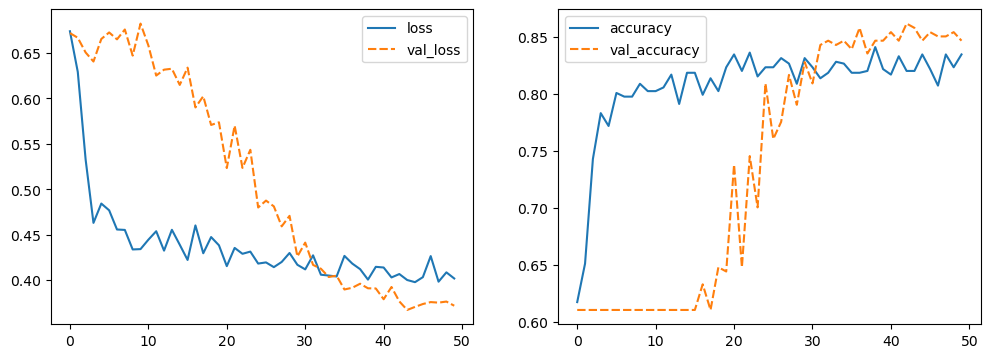

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

hist_frame=pd.DataFrame(data=history.history)
plt.figure(figsize=(12,9))
plt.subplot(2,2,1)
sns.lineplot(data=(hist_frame.loss, hist_frame.val_loss))
plt.subplot(2,2,2)
sns.lineplot(data=(hist_frame.accuracy, hist_frame.val_accuracy))

### predictions test data

In [128]:
test_model_predictions = final_model.predict(test_df)

14/14 [==============================] - 0s 2ms/step


### create submission.csv file

In [129]:
# now predict on Test dataset and copy to CSV

test_model_data = pd.DataFrame()
test_model_data['PassengerId'] = passengerId

test_model_data['Survived'] = [0 if pred < 0.5 else 1 for pred in test_model_predictions]
test_model_data.to_csv('submission.csv', index = False)


In [130]:
!head submission.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,0
897,0
898,1
899,0
900,0


<u>For more information on hyper-parameter search also chekout:</u><br>
[Grid Search Hyperparameters for Deep Learning Models - Jason Brownlee](https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/)<br>
[Tuning the Hyperparameters and Layers of NN Deep Learning - Rendyk](https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/)

[JBL]:https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras

[RDK]:https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning